In [1]:
def car(env):
    while True:
        print('Start parking at %d' % env.now)
        parking_duration = 5
        yield env.timeout(parking_duration)
        print('Start driving at %d' % env.now)
        trip_duration = 2
        yield env.timeout(trip_duration)

import simpy
env = simpy.Environment()
env.process(car(env))
env.run(until=15)

Start parking at 0
Start driving at 5
Start parking at 7
Start driving at 12
Start parking at 14


In [1]:
"""
Gas Station Refueling example

Covers:

- Resources: Resource
- Resources: Container
- Waiting for other processes

Scenario:
  A gas station has a limited number of gas pumps that share a common
  fuel reservoir. Cars randomly arrive at the gas station, request one
  of the fuel pumps and start refueling from that reservoir.

  A gas station control process observes the gas station's fuel level
  and calls a tank truck for refueling if the station's level drops
  below a threshold.

"""
import itertools
import random
import matplotlib.pyplot as plt

import simpy

def car(name, env, gas_station, fuel_pump):
    """A car arrives at the gas station for refueling.

    It requests one of the gas station's fuel pumps and tries to get the
    desired amount of gas from it. If the stations reservoir is
    depleted, the car has to wait for the tank truck to arrive.

    """
    fuel_tank_level = random.randint(*FUEL_TANK_LEVEL)
    #print('%s arriving at gas station at %.1f' % (name, env.now))
    with gas_station.request() as req:
        start = env.now
        # Request one of the gas pumps
        yield req

        # Get the required amount of fuel
        liters_required = FUEL_TANK_SIZE - fuel_tank_level
        yield fuel_pump.get(liters_required)

        # The "actual" refueling process takes some time
        yield env.timeout(liters_required / REFUELING_SPEED)

        #print('%s finished refueling in %.1f seconds.' % (name,
        #                                                  env.now - start))


def gas_station_control(env, fuel_pump):
    """Periodically check the level of the *fuel_pump* and call the tank
    truck if the level falls below a threshold."""
    while True:
        #print('>>>>', fuel_pump.level)
        #print('Queue len : %s'%len(gas_station.queue))
        log.append(len(gas_station.queue))
        if fuel_pump.level / fuel_pump.capacity * 100 < THRESHOLD:
            # We need to call the tank truck now!
            print('Calling tank truck at %d' % env.now)
            # Wait for the tank truck to arrive and refuel the station
            yield env.process(tank_truck(env, fuel_pump))

        yield env.timeout(10)  # Check every 10 seconds


def tank_truck(env, fuel_pump):
    """Arrives at the gas station after a certain delay and refuels it."""
    yield env.timeout(TANK_TRUCK_TIME)
    print('Tank truck arriving at time %d' % env.now)
    ammount = fuel_pump.capacity - fuel_pump.level
    print('Tank truck refuelling %.1f liters.' % ammount)
    yield fuel_pump.put(ammount)


def car_generator(env, gas_station, fuel_pump):
    """Generate new cars that arrive at the gas station."""
    for i in itertools.count():
        yield env.timeout(random.randint(*T_INTER))
        if len(gas_station.queue)<=QUEUE_CAPACITY:
            env.process(car('Car %d' % i, env, gas_station, fuel_pump))

Gas Station refuelling


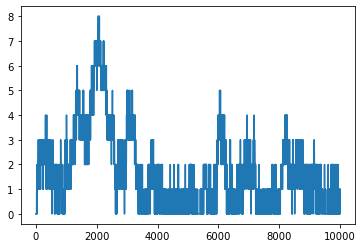

In [5]:
RANDOM_SEED = 42
GAS_STATION_SIZE = 200000     # liters
THRESHOLD = 1             # Threshold for calling the tank truck (in %)
FUEL_TANK_SIZE = 50        # liters
FUEL_TANK_LEVEL = [5, 25]  # Min/max levels of fuel tanks (in liters)
REFUELING_SPEED = 0.2        # liters / second
TANK_TRUCK_TIME = 300      # Seconds it takes the tank truck to arrive
T_INTER = [45, 130]        # Create a car every [min, max] seconds
SIM_TIME = 100000            # Simulation time in seconds
QUEUE_CAPACITY = 10
NUMBER_PUMPS = 2

# Setup and start the simulation
print('Gas Station refuelling')
random.seed(RANDOM_SEED)

# Create environment and start processes
log = []
env = simpy.Environment()
gas_station = simpy.Resource(env, NUMBER_PUMPS)
fuel_pump = simpy.Container(env, GAS_STATION_SIZE, init=GAS_STATION_SIZE)
env.process(gas_station_control(env, fuel_pump))
env.process(car_generator(env, gas_station, fuel_pump))

# Execute!
env.run(until=SIM_TIME)

plt.plot(log)